In [1]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.metrics import accuracy_score
# Import the wordcloud library
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [4]:
import os
pwd = os.getcwd()

In [5]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [6]:
emails.count()

file       517401
message    517401
dtype: int64

In [50]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[1000:3000]
print(email_subset.shape)
print(email_subset.head())

(2000, 2)
                            file  \
1000  allen-p/all_documents/462.   
1001  allen-p/all_documents/463.   
1002  allen-p/all_documents/464.   
1003  allen-p/all_documents/465.   
1004  allen-p/all_documents/466.   

                                                message  
1000  Message-ID: <1081797.1075855696183.JavaMail.ev...  
1001  Message-ID: <28830232.1075855696211.JavaMail.e...  
1002  Message-ID: <23711632.1075855696233.JavaMail.e...  
1003  Message-ID: <28968716.1075855696255.JavaMail.e...  
1004  Message-ID: <2413536.1075855696276.JavaMail.ev...  


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [51]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [52]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0,
        'print': np.nan
    }

In [53]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [54]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [55]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))

In [56]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 07",0,0,0,0,NaN
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 06",0,0,0,0,NaN
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,"Thu, 15 Mar 2001 04",0,0,0,0,NaN


In [57]:
email_df.count()

body     1888
to       1888
from_    1888
date     1888
TC       1888
SN       1888
KS       1888
OT       1888
print       0
dtype: int64

In [58]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][1]

'I also need to know the base salaries of Jay Reitmeyer and Monique Sanchez.They are doing the same job as Matt.'

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [59]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [60]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [61]:
email_df['text_processed'][1]

'i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

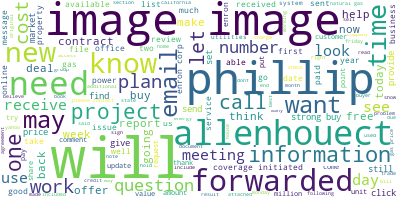

In [62]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [63]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [64]:

vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
# X = vect.fit_transform(email_df.text_processed)

In [65]:
email_df.to_pickle('email.pickle')


In [ ]:
# def manually_label(email_file):
    
df = pd.read_pickle('email.pickle')
for index, row in df.iterrows():
        print('Is this sentence? Type 1 if team communication,',
              '\nType 2: social networking,','\nType 3:  knowledge sharing and ',
              '\nType 4: others . \n')
        print(row.text_processed)
        label = input()
        print(label)
        if '1' in label:
            df.loc[index, 'TC'] = 1
        if '2' in label:
            df.loc[index, 'SN'] = 1
        if '3' in label:
            df.loc[index, 'KS'] = 1
        if '4' in label:
            df.loc[index, 'OT'] = 1
        if label == '':
            df.loc[index, 'OT'] = 1
        clear_output()
        
        df.to_pickle('email.pickle')
        
print('No more labels to classify!')
    


In [ ]:
df.head(5)

In [ ]:
df.to_csv(os.path.basename(pwd +'/final_result1.csv'))

In [67]:
df = pd.read_csv(os.path.basename(pwd +'/final_result.csv'))

In [68]:
df.head()

,Unnamed: 0,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14 May 2001,1,0,0,0,NaN,here is our forecast
1,1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4 May 2001,0,1,0,0,NaN,traveling to have a business meeting takes the...
2,2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18 Oct 2000,1,0,0,0,NaN,test successful way to go
3,3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,23 Oct 2000,1,0,0,0,NaN,randycan you send me a schedule of the salary ...
4,5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,31 Aug 2000,0,1,0,0,NaN,greghow about either next tuesday or thursdayp...


In [24]:
df.count()

Unnamed: 0        978
body              978
to                978
from_             978
date              978
TC                978
SN                978
KS                978
OT                978
print               0
text_processed    978
dtype: int64

In [25]:
categories = ['TC','SN','KS','OT']

In [26]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))

In [27]:
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,TC,650
1,SN,240
2,KS,145
3,OT,77


Text(0.5, 0, 'category')

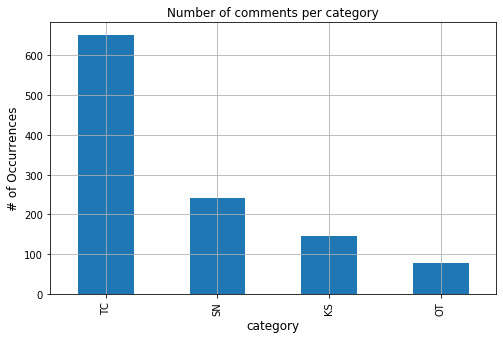

In [28]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

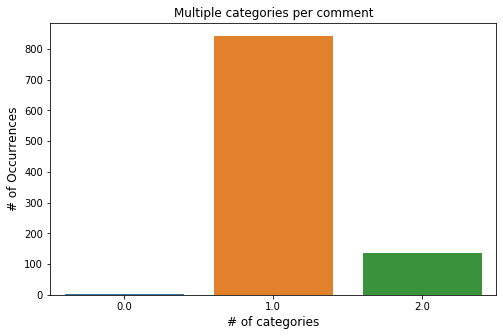

In [29]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [69]:
from sklearn.model_selection import train_test_split
categories = ['TC', 'SN', 'KS', 'OT']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.text_processed
X_test = test.text_processed
print(X_train.shape)
print(X_test.shape)

(655,)
(323,)


In [73]:
X_train.head()

172    maryif we add both balances together the total...
125    timcan you authorize access to the west power ...
750    janemtholtenroncom mikegrigsbyenroncomtranswes...
398    georgei am back in the office and ready to foc...
882    forwarded by phillip k allenhouect on 05022001...
Name: text_processed, dtype: object

In [33]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Naive Bayes

In [35]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [38]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.7120743034055728
... Processing SN
Test accuracy is 0.7523219814241486
... Processing KS
Test accuracy is 0.8637770897832817
... Processing OT
Test accuracy is 0.9256965944272446


### Linear SVC

In [39]:
from sklearn.svm import LinearSVC
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


In [40]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.7770897832817337
... Processing SN
Test accuracy is 0.8018575851393189
... Processing KS
Test accuracy is 0.9009287925696594
... Processing OT
Test accuracy is 0.9473684210526315


### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


In [42]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.7306501547987616
... Processing SN
Test accuracy is 0.7585139318885449
... Processing KS
Test accuracy is 0.8730650154798761
... Processing OT
Test accuracy is 0.9473684210526315


### Artificial Neural Network

In [46]:
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))

In [47]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [49]:
# model_history = model.fit(X_train,Y_train,epochs=30)

### SVM

In [43]:
from sklearn.svm import SVC
SVM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', SVC()),
            ])

In [44]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVM_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVM_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing TC
Test accuracy is 0.7461300309597523
... Processing SN
Test accuracy is 0.7925696594427245
... Processing KS
Test accuracy is 0.8978328173374613
... Processing OT
Test accuracy is 0.9504643962848297


#### Linear SVC  performed better as compared to other models

In [66]:
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,lucyhere is the rentrollmy only questions are ...
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,i also need to know the base salaries of jay r...
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,thanks for the information it would be helpful...
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,15 Mar 2001,0,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...


In [83]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(email_df['text_processed'])
    email_df[category] = prediction

... Processing TC
... Processing SN
... Processing KS
... Processing OT


In [88]:
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,"Lucy,Here is the rentroll.My only questions ar...",stagecoachmama@hotmail.com,phillip.allen@enron.com,15 Mar 2001,0,1,0,0,NaN,lucyhere is the rentrollmy only questions are ...
1,I also need to know the base salaries of Jay R...,todd.burke@enron.com,phillip.allen@enron.com,15 Mar 2001,0,1,0,0,NaN,i also need to know the base salaries of jay r...
2,---------------------- Forwarded by Phillip K ...,Western.Price.Survey.contacts@ren-10.cais.net,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...
3,Thanks for the information. It would be helpf...,kim.bolton@enron.com,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,thanks for the information it would be helpful...
4,---------------------- Forwarded by Phillip K ...,Phillip.K.Allen@enron.com,phillip.allen@enron.com,15 Mar 2001,1,0,0,0,NaN,forwarded by phillip k allenhouect on 03152001...


In [89]:
df.to_csv(os.path.basename(pwd +'/final_test.csv'))

In [93]:
print(email_df.iloc[1]['text_processed'])

i also need to know the base salaries of jay reitmeyer and monique sanchezthey are doing the same job as matt


In [94]:
data = email_df.text_processed.values.tolist()

In [95]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [96]:
data_words = list(sent_to_words(data))

In [97]:
print(data_words[1])

['also', 'need', 'to', 'know', 'the', 'base', 'salaries', 'of', 'jay', 'reitmeyer', 'and', 'monique', 'sanchezthey', 'are', 'doing', 'the', 'same', 'job', 'as', 'matt']


In [98]:
# ugs = word_tokenize(raw)
# bgs = nltk.bigrams(ugs)
# tgs = nltk.trigrams(ugs)
# fogs=nltk.ngrams(ugs,4)
# figs=nltk.ngrams(ugs,5)

In [99]:
# # Build the bigram and trigram models
# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [100]:
# # Faster way to get a sentence clubbed as a trigram/bigram
# # bigram_mod = Phraser(bigram)
# # trigram_mod = Phraser(trigram)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [101]:
# print(bigram_mod[data_words[11]])

In [102]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [103]:
#  Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

In [104]:
# data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = lemmatization(data_words_nostops)

In [105]:
print(data_lemmatized[1])

['also', 'need', 'know', 'base', 'salary', 'jay', 'reitmeyer', 'monique', 'sanchezthey', 'job', 'matt']


### Bag of Words on the Data set

In [106]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [107]:
print('Number of unique words in initital documents:', len(dictionary))

Number of unique words in initital documents: 16344


In [108]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words after removing rare and common words: 1344


In [109]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ad
1 discount
2 five
3 going
4 letter
5 like
6 look
7 lucyhere
8 missed
9 need
10 next


### Gensim doc2bow

In [110]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[489]

[(56, 1),
 (105, 3),
 (118, 1),
 (186, 1),
 (200, 1),
 (290, 1),
 (415, 2),
 (440, 1),
 (521, 1),
 (589, 1),
 (682, 1),
 (729, 1),
 (871, 1),
 (925, 1),
 (1028, 1),
 (1039, 1),
 (1299, 1)]

In [111]:
bow_doc_489 = bow_corpus[489]
for i in range(len(bow_doc_489)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_489[i][0], 
                                               dictionary[bow_doc_489[i][0]], 
bow_doc_489[i][1]))

Word 56 ("please") appears 1 time.
Word 105 ("email") appears 3 time.
Word 118 ("austin") appears 1 time.
Word 186 ("service") appears 1 time.
Word 200 ("tx") appears 1 time.
Word 290 ("receive") appears 1 time.
Word 415 ("message") appears 2 time.
Word 440 ("common") appears 1 time.
Word 521 ("line") appears 1 time.
Word 589 ("road") appears 1 time.
Word 682 ("thank") appears 1 time.
Word 729 ("wish") appears 1 time.
Word 871 ("joe") appears 1 time.
Word 925 ("address") appears 1 time.
Word 1028 ("south") appears 1 time.
Word 1039 ("longer") appears 1 time.
Word 1299 ("replyto") appears 1 time.


### TF-IDF

In [112]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    if doc != []:
        pprint(doc)
        break

[(0, 0.3013197954885115),
 (1, 0.28339212170251354),
 (2, 0.2720302687844622),
 (3, 0.1643938997545552),
 (4, 0.24851817489694025),
 (5, 0.11360270062920255),
 (6, 0.14179855165841324),
 (7, 0.2541025949984642),
 (8, 0.2746824843961455),
 (9, 0.10156347516456478),
 (10, 0.18435470138731772),
 (11, 0.13396089765249478),
 (12, 0.23285684762153333),
 (13, 0.27745261425439766),
 (14, 0.19938335662233636),
 (15, 0.20356732091748403),
 (16, 0.16168400930236546),
 (17, 0.12853855218255927),
 (18, 0.1427697556383092),
 (19, 0.2670421944846301),
 (20, 0.28995794257046015)]


### LDA using Bag of Words

In [113]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10, 
                                       id2word=dictionary,
                                       passes=2, workers=2)

In [114]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.139*"image" + 0.017*"change" + 0.012*"power" + 0.012*"story" + 0.011*"full" + 0.008*"market" + 0.007*"close" + 0.007*"gas" + 0.007*"plant" + 0.007*"new"
Topic: 1 
Words: 0.017*"cost" + 0.014*"loan" + 0.009*"would" + 0.009*"please" + 0.007*"phillip" + 0.006*"u" + 0.006*"email" + 0.006*"time" + 0.006*"market" + 0.006*"land"
Topic: 2 
Words: 0.011*"please" + 0.010*"position" + 0.009*"image" + 0.009*"need" + 0.007*"gas" + 0.007*"would" + 0.007*"new" + 0.007*"phillip" + 0.006*"yes" + 0.006*"power"
Topic: 3 
Words: 0.033*"email" + 0.018*"gas" + 0.011*"please" + 0.009*"phillip" + 0.007*"u" + 0.007*"forwarded" + 0.007*"price" + 0.007*"trade" + 0.007*"make" + 0.006*"allenhouect"
Topic: 4 
Words: 0.033*"phillip" + 0.029*"forwarded" + 0.026*"allenhouect" + 0.012*"please" + 0.007*"need" + 0.007*"contact" + 0.007*"project" + 0.006*"date" + 0.006*"email" + 0.006*"file"
Topic: 5 
Words: 0.048*"buy" + 0.017*"downgraded" + 0.014*"strong" + 0.013*"would" + 0.012*"initiated" + 0.011*"c

### Running LDA using TF-IDF

In [115]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                             id2word=dictionary,
                                             passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"buy" + 0.006*"gas" + 0.006*"basis" + 0.006*"phillip" + 0.005*"enron" + 0.005*"forwarded" + 0.005*"market" + 0.005*"corp" + 0.005*"allenhouect" + 0.005*"deal"
Topic: 1 Word: 0.021*"image" + 0.007*"rent" + 0.007*"missed" + 0.007*"guest" + 0.007*"san" + 0.007*"comment" + 0.007*"phillip" + 0.006*"gas" + 0.006*"forwarded" + 0.006*"email"
Topic: 2 Word: 0.010*"phillip" + 0.010*"forwarded" + 0.010*"allenhouect" + 0.008*"would" + 0.006*"yes" + 0.005*"please" + 0.005*"message" + 0.004*"cost" + 0.004*"original" + 0.004*"tim"
Topic: 3 Word: 0.008*"phillip" + 0.007*"forwarded" + 0.006*"allenhouect" + 0.006*"new" + 0.006*"check" + 0.005*"spreadsheet" + 0.005*"time" + 0.005*"socal" + 0.005*"go" + 0.005*"need"
Topic: 4 Word: 0.006*"email" + 0.006*"please" + 0.006*"file" + 0.005*"would" + 0.005*"work" + 0.005*"send" + 0.005*"desk" + 0.005*"report" + 0.004*"going" + 0.004*"intelligence"
Topic: 5 Word: 0.007*"load" + 0.006*"zdnet" + 0.006*"gas" + 0.006*"original" + 0.006*"update" +

In [116]:
for index, score in sorted(lda_model[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.3426913619041443	 
Topic: 0.033*"phillip" + 0.029*"forwarded" + 0.026*"allenhouect" + 0.012*"please" + 0.007*"need" + 0.007*"contact" + 0.007*"project" + 0.006*"date" + 0.006*"email" + 0.006*"file"

Score: 0.34148046374320984	 
Topic: 0.033*"email" + 0.018*"gas" + 0.011*"please" + 0.009*"phillip" + 0.007*"u" + 0.007*"forwarded" + 0.007*"price" + 0.007*"trade" + 0.007*"make" + 0.006*"allenhouect"

Score: 0.2824830412864685	 
Topic: 0.013*"message" + 0.012*"please" + 0.010*"new" + 0.010*"email" + 0.009*"yahoo" + 0.009*"enron" + 0.009*"recipient" + 0.009*"contract" + 0.008*"free" + 0.008*"time"


In [117]:
for index, score in sorted(lda_model_tfidf[bow_corpus[489]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.7534192800521851	 
Topic: 0.010*"phillip" + 0.010*"forwarded" + 0.010*"allenhouect" + 0.008*"would" + 0.006*"yes" + 0.005*"please" + 0.005*"message" + 0.004*"cost" + 0.004*"original" + 0.004*"tim"

Score: 0.20846998691558838	 
Topic: 0.010*"buy" + 0.006*"gas" + 0.006*"basis" + 0.006*"phillip" + 0.005*"enron" + 0.005*"forwarded" + 0.005*"market" + 0.005*"corp" + 0.005*"allenhouect" + 0.005*"deal"
